In [6]:
# installation des dependences pour le projeet
#pip install numpy pandas matplotlib pillow torch torchvision scikit-learn seaborn

In [8]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import torch
from torch import nn, optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

print("PyTorch version:", torch.__version__)

PyTorch version: 2.9.1+cu128


In [9]:
import torch
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))
    print("VRAM:", torch.cuda.get_device_properties(0).total_memory / 1024**3, "GB")
else:
    print("CUDA non disponible")

GPU: NVIDIA GeForce RTX 5070 Ti
VRAM: 15.47705078125 GB


In [16]:
#pip install kagglehub
import kagglehub

# Download latest version
path = kagglehub.dataset_download("obulisainaren/multi-cancer")



Path to dataset files: /root/.cache/kagglehub/datasets/obulisainaren/multi-cancer/versions/3


In [18]:
print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/obulisainaren/multi-cancer/versions/3


In [24]:
import os
from shutil import copyfile
from sklearn.model_selection import train_test_split

print("Imports OK")

Imports OK


In [28]:
import os
from shutil import copyfile
from sklearn.model_selection import train_test_split

# --- Find "Brain Cancer" folder inside the downloaded dataset (robust) ---
brain_folder = None
for root, dirs, files in os.walk(path):
    if os.path.basename(root) == "Brain Cancer":
        brain_folder = root
        break

if brain_folder is None:
    raise FileNotFoundError("Folder 'Brain Cancer' not found inside kagglehub download path.")

image_folder = brain_folder
print("Using image_folder:", image_folder)

# Class folders
glioma_folder = os.path.join(image_folder, "brain_glioma")
menin_folder  = os.path.join(image_folder, "brain_menin")
tumor_folder  = os.path.join(image_folder, "brain_tumor")

# Output folders
train_folder = "/kaggle/working/train_data"
test_folder  = "/kaggle/working/test_data"
os.makedirs(train_folder, exist_ok=True)
os.makedirs(test_folder, exist_ok=True)

def split_and_copy(class_folder, train_output_folder, test_output_folder, test_size=0.2, seed=42):
    if not os.path.isdir(class_folder):
        raise FileNotFoundError(f"Class folder not found: {class_folder}")

    images = [
        os.path.join(class_folder, img)
        for img in os.listdir(class_folder)
        if img.lower().endswith((".jpg", ".jpeg", ".png"))
    ]

    if len(images) == 0:
        print(f"[WARN] No images found in {class_folder}")
        return

    train_images, test_images = train_test_split(
        images, test_size=test_size, random_state=seed, shuffle=True
    )

    os.makedirs(train_output_folder, exist_ok=True)
    os.makedirs(test_output_folder, exist_ok=True)

    for img in train_images:
        dest_path = os.path.join(train_output_folder, os.path.basename(img))
        if not os.path.exists(dest_path):
            copyfile(img, dest_path)

    for img in test_images:
        dest_path = os.path.join(test_output_folder, os.path.basename(img))
        if not os.path.exists(dest_path):
            copyfile(img, dest_path)

# Run split for 3 classes
split_and_copy(glioma_folder, os.path.join(train_folder, "brain_glioma"), os.path.join(test_folder, "brain_glioma"))
split_and_copy(menin_folder,  os.path.join(train_folder, "brain_menin"),  os.path.join(test_folder, "brain_menin"))
split_and_copy(tumor_folder,  os.path.join(train_folder, "brain_tumor"),  os.path.join(test_folder, "brain_tumor"))

print("contenu_train_folder:", os.listdir(train_folder))
print("contenu_test_folder:", os.listdir(test_folder))


Using image_folder: /root/.cache/kagglehub/datasets/obulisainaren/multi-cancer/versions/3/Multi Cancer/Multi Cancer/Brain Cancer
contenu_train_folder: ['brain_glioma', 'brain_menin', 'brain_tumor']
contenu_test_folder: ['brain_glioma', 'brain_menin', 'brain_tumor']


In [29]:
def count_images(folder):
    total = 0
    for c in os.listdir(folder):
        class_folder = os.path.join(folder, c)
        if os.path.isdir(class_folder):
            n = len([
                f for f in os.listdir(class_folder)
                if f.lower().endswith(('.jpg', '.jpeg', '.png'))
            ])
            print(f"{folder} | {c}: {n} gambar")
            total += n
    print("Total:", total)

print("Train data counts:")
count_images(train_folder)

print("\nTest data counts:")
count_images(test_folder)

Train data counts:
/kaggle/working/train_data | brain_glioma: 4000 gambar
/kaggle/working/train_data | brain_menin: 4000 gambar
/kaggle/working/train_data | brain_tumor: 4000 gambar
Total: 12000

Test data counts:
/kaggle/working/test_data | brain_glioma: 1000 gambar
/kaggle/working/test_data | brain_menin: 1000 gambar
/kaggle/working/test_data | brain_tumor: 1000 gambar
Total: 3000


In [30]:
# Augmentation pour train, simple transform pour val/test
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Dataset complet depuis train_folder
full_train_dataset = datasets.ImageFolder(root=train_folder, transform=train_transforms)
test_dataset       = datasets.ImageFolder(root=test_folder,  transform=test_transforms)

class_names = full_train_dataset.classes
print("Classes:", class_names)
print("le nombre d'images train:", len(full_train_dataset))
print("le nombre d'images test :", len(test_dataset))


Classes: ['brain_glioma', 'brain_menin', 'brain_tumor']
Jumlah gambar train: 12000
Jumlah gambar test : 3000


In [31]:
from torch.utils.data import DataLoader, random_split

batch_size = 32
val_ratio = 0.2

val_size = int(val_ratio * len(full_train_dataset))
train_size = len(full_train_dataset) - val_size

train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

print(f"Train size: {train_size}, Val size: {val_size}")

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)

Train size: 9600, Val size: 2400


In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=3):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 7 * 7, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = SimpleCNN(num_classes=len(class_names)).to(device)
print(model)

Device: cuda
SimpleCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_runnin

In [33]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=5e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                 factor=0.3, patience=3,
                                                 min_lr=1e-5)

In [34]:
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

In [35]:
import time
import json
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# -------------------------
# Exemple: class_names (mets les tiens dans le bon ordre)
# IMPORTANT: ordre = même que ton dataset / ImageFolder
# -------------------------
class_names = ["brain_glioma", "brain_menin", "brain_tumor"]

# -------------------------
# modèle (entrée 512x512 => sortie 16x16 après 5 pool)
# -------------------------
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(128, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(256, 512, 3, padding=1), nn.BatchNorm2d(512), nn.ReLU(), nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 7 * 7, 512),   
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)



# -------------------------
# Fonctions train / eval 
# -------------------------
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad(set_to_none=True)
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return running_loss / total, correct / total


@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * images.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return running_loss / total, correct / total


# -------------------------
# SAVE / LOAD checkpoint complet
# -------------------------
def save_checkpoint(path, model, optimizer, epoch, best_val_loss, class_names, img_size=512):
    ckpt = {
        "epoch": epoch,
        "best_val_loss": float(best_val_loss),
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "class_names": class_names,
        "img_size": img_size,  # utile pour l'API (resize)
    }
    torch.save(ckpt, path)
    print(f"[OK] Checkpoint saved to: {path}")


def main_train(train_loader, val_loader, num_epochs=30, lr=5e-4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Device:", device)

    model = SimpleCNN(num_classes=len(class_names)).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    best_val_loss = np.inf
    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": [], "epoch_time_sec": []}

    t_train_start = time.perf_counter()

    for epoch in range(num_epochs):
        t0 = time.perf_counter()

        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)

        epoch_time = time.perf_counter() - t0
        history["epoch_time_sec"].append(epoch_time)

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)

        # Save best checkpoint
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            save_checkpoint(
                path="checkpoint_best.pth",
                model=model,
                optimizer=optimizer,
                epoch=epoch + 1,
                best_val_loss=best_val_loss,
                class_names=class_names,
                img_size=512
            )

        avg_time = sum(history["epoch_time_sec"]) / len(history["epoch_time_sec"])
        eta = avg_time * (num_epochs - (epoch + 1))

        print(
            f"Epoch [{epoch+1}/{num_epochs}] "
            f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | "
            f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f} | "
            f"Time: {epoch_time:.1f}s | ETA: {eta/60:.1f} min"
        )

    total_time = time.perf_counter() - t_train_start
    print(f"Training complete. Total time: {total_time/60:.1f} min")

    # Save last checkpoint too
    save_checkpoint(
        path="checkpoint_last.pth",
        model=model,
        optimizer=optimizer,
        epoch=num_epochs,
        best_val_loss=best_val_loss,
        class_names=class_names,
        img_size=512
    )

    # Optionnel: sauvegarder history en json
    with open("history.json", "w") as f:
        json.dump(history, f)

    return model, history



In [36]:
model, history = main_train(train_loader, val_loader, num_epochs=30, lr=5e-4)

Device: cuda
[OK] Checkpoint saved to: checkpoint_best.pth
Epoch [1/30] Train Loss: 0.7785 Acc: 0.6915 | Val Loss: 1.3788 Acc: 0.5575 | Time: 91.2s | ETA: 44.1 min
[OK] Checkpoint saved to: checkpoint_best.pth
Epoch [2/30] Train Loss: 0.4649 Acc: 0.8246 | Val Loss: 0.6745 Acc: 0.6804 | Time: 67.0s | ETA: 36.9 min
Epoch [3/30] Train Loss: 0.3302 Acc: 0.8792 | Val Loss: 1.9477 Acc: 0.4783 | Time: 78.9s | ETA: 35.6 min
[OK] Checkpoint saved to: checkpoint_best.pth
Epoch [4/30] Train Loss: 0.2951 Acc: 0.8889 | Val Loss: 0.3369 Acc: 0.8429 | Time: 71.0s | ETA: 33.4 min
Epoch [5/30] Train Loss: 0.2593 Acc: 0.9021 | Val Loss: 0.6338 Acc: 0.7750 | Time: 112.9s | ETA: 35.1 min
Epoch [6/30] Train Loss: 0.2369 Acc: 0.9144 | Val Loss: 0.4553 Acc: 0.8075 | Time: 97.9s | ETA: 34.6 min
Epoch [7/30] Train Loss: 0.2181 Acc: 0.9216 | Val Loss: 0.3956 Acc: 0.8404 | Time: 64.7s | ETA: 32.0 min
[OK] Checkpoint saved to: checkpoint_best.pth
Epoch [8/30] Train Loss: 0.1928 Acc: 0.9283 | Val Loss: 0.2558 Acc:

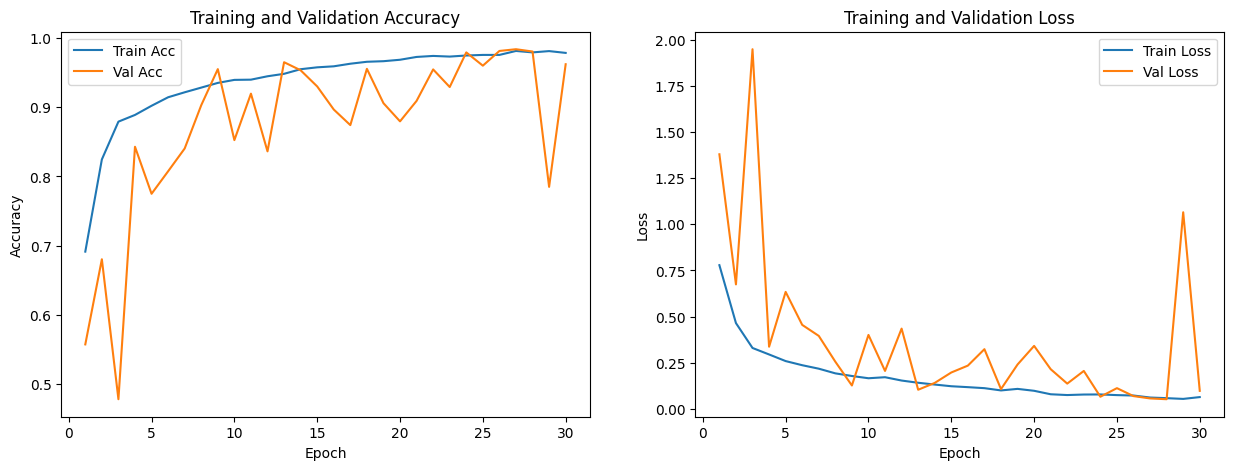

In [37]:
epochs_range = range(1, len(history["train_acc"]) + 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy
ax1.plot(epochs_range, history["train_acc"], label='Train Acc')
ax1.plot(epochs_range, history["val_acc"], label='Val Acc')
ax1.set_title("Training and Validation Accuracy")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Accuracy")
ax1.legend()

# Loss
ax2.plot(epochs_range, history["train_loss"], label='Train Loss')
ax2.plot(epochs_range, history["val_loss"], label='Val Loss')
ax2.set_title("Training and Validation Loss")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Loss")
ax2.legend()

plt.show()

In [ ]:
#Api pour faire des appelle aux model sauvgarder 
from fastapi import FastAPI, File, UploadFile, HTTPException
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import torchvision.transforms as T
import io

# -------- Model (IDENTIQUE à l'entraînement) --------
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(128, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(256, 512, 3, padding=1), nn.BatchNorm2d(512), nn.ReLU(), nn.MaxPool2d(2),

            #la sortie toujours en 7x7 (évite mismatch si img_size != 224)
            nn.AdaptiveAvgPool2d((7, 7)),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 7 * 7, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)

# -------- Load checkpoint --------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ckpt = torch.load("checkpoint_best.pth", map_location=device)

class_names = ckpt["class_names"]
img_size = int(ckpt.get("img_size", 224))  # taille utilisée pour resize

model = SimpleCNN(num_classes=len(class_names)).to(device)
model.load_state_dict(ckpt["model_state_dict"])
model.eval()

# -------- Preprocess --------
transform = T.Compose([
    T.Resize((img_size, img_size)),
    T.ToTensor(),
    # Si tu avais Normalize à l'entraînement, ajoute-le ici !
])

app = FastAPI(title="Cancer Classification API", version="1.0")

@app.get("/")
def root():
    return {"status": "ok", "device": str(device), "classes": class_names}

@app.post("/predict")
async def predict(file: UploadFile = File(...)):
    if file.content_type not in ["image/jpeg", "image/png", "image/jpg"]:
        raise HTTPException(status_code=400, detail="Upload a JPG or PNG image")

    img_bytes = await file.read()

    try:
        img = Image.open(io.BytesIO(img_bytes)).convert("RGB")
    except Exception:
        raise HTTPException(status_code=400, detail="Invalid image file")

    x = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        logits = model(x)
        probs = F.softmax(logits, dim=1)[0]
        pred_idx = int(torch.argmax(probs).item())

    confidence = float(probs[pred_idx].item())

    return {
        "predicted_index": pred_idx,
        "predicted_label": class_names[pred_idx],
        "confidence": confidence,
        "confidence_pct": round(confidence * 100, 2),
        "probabilities": {
            class_names[i]: round(float(probs[i].item()) * 100, 2)
            for i in range(len(class_names))
        }
    }




In [ ]:
#tester la classification 
import os
import mimetypes
import requests

API_URL = "http://localhost:8000/predict"
IMAGE_DIR = r"C:\Users\User\Desktop\Cancer\Brain Cancer\brain_glioma"
THRESHOLD = 0.70

total = 0
correct_high_conf = 0

for fname in os.listdir(IMAGE_DIR):
    if not fname.lower().endswith((".jpg", ".jpeg", ".png")):
        continue

    total += 1
    path = os.path.join(IMAGE_DIR, fname)

    mime, _ = mimetypes.guess_type(path)
    if mime is None:
        mime = "image/jpeg"

    with open(path, "rb") as f:
        r = requests.post(API_URL, files={"file": (fname, f, mime)})

    if r.status_code != 200:
        print(f"[ERROR] {fname}: {r.status_code} -> {r.text}")
        continue

    data = r.json()
    label = data["predicted_label"]
    conf = data["confidence"]

    if label == "brain_glioma" and conf >= THRESHOLD:
        correct_high_conf += 1

    print(f"{fname:35s} -> {label:12s} | {conf*100:5.1f}%")

print("\n================ RESULTATS ================")
print(f"Total images testées : {total}")
print(f"Prédites 'brain_glioma' avec confiance > 70% : {correct_high_conf}")
print(f"Pourcentage : {100*correct_high_conf/total:.2f}%")
